In [1]:

from matplotlib import pyplot as plt
from random import randint
import os
from matplotlib.pyplot import imshow
import scipy.ndimage
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
from sklearn.metrics import f1_score

# Preparing the dataset
# Setup train and test splits


In [2]:
from sklearn import preprocessing

def sigmoid(X):
    return 1/(1 + np.exp(-X));

def relu(X):
    return np.maximum(0,X);

def swish(x,y):
    return x*y;

def derv_sigmoid(x):
    return x*(1-x);

def derv_relu(x):
    sh = x.shape;
    m = sh[0];
    n = sh[1];
    z = np.ones((m,n));
    z = z*(x>0);
    return z;

def derv_swish(x,y):
    return (x+y*(1-x));



def forwardPropogation (X,Y,netConfig,batch_size,lr,total_epochs,act = "sigmoid"):
        
    sh = X.shape;
    m = sh[0]; #number of examples.
    n = sh[1]; #number of features.
    
    X0 = np.ones((m,1))
    X_new = np.hstack((X,X0))
    X_new = np.transpose(X_new);
    
    Y_new = np.transpose(Y);
    
    #Initialize Weights
    wt = {};
    total_layers = len(netConfig);
    wt_layers= total_layers - 1;
    
    for i in range(wt_layers):
        if(i == 0):
            wt["wt_hidden"+str(i)] = np.random.uniform(-5.0,5.0,[netConfig[i + 1], netConfig[i] +1])/n;
        else:
            wt["wt_hidden"+str(i)] = np.random.uniform(-5.0,5.0,[netConfig[i + 1], netConfig[i] +1]);
    
    params = {};
    act_layer = {};
    act_layer_bias = {};
    #act_layer_bias["hidden_output_bias0"] = X_new;
    
    A = np.vstack((X_new,Y_new));
    for epoch in range(total_epochs):
        
        Ap = A[:,np.random.randint(A.shape[1], size=batch_size)];
        X_new1 = Ap[0:n+1,:];
        Y_new1 = Ap[n+1:Ap.size,:]
        #print(X_new1);
        #print("forward propogation")
        #print(Y_new1)
        act_layer_bias["hidden_output_bias0"] = X_new1;
        
        for i in range(wt_layers):
            prev_wt = wt["wt_hidden"+str(i)];
            prev_ho =  act_layer_bias["hidden_output_bias"+str(i)];
            hidden_input = np.matmul(prev_wt,prev_ho);
            
            if(i+1 < wt_layers):
                
                if(act == "sigmoid"):
                    hidden_output1 = sigmoid(hidden_input);
                
                elif(act == "swish"):
                    hidden_output1 = sigmoid(hidden_input);
                    act_layer["sigmoid_output"+str(i+1)] = hidden_output1;
                    hidden_output1 = swish(hidden_input,hidden_output1);
                
                elif(act == "relu"):
                    act_layer["hidden_input"+str(i+1)] = hidden_input;
                    hidden_output1 = relu(hidden_input);
    
                hidden_output = np.vstack((hidden_output1,np.ones((1,batch_size)))); #p+1Xm
                act_layer_bias["hidden_output_bias" + str(i+1)] = hidden_output;
            else:
                hidden_output1 = sigmoid(hidden_input);
                #print(hidden_output1);
            act_layer["hidden_output"+str(i+1)] = hidden_output1;
            #print("hidd")
            #print(hidden_output1)
        wt = backwardPropogation(wt,netConfig,act_layer,act_layer_bias,Y_new1,(lr/batch_size),act);
    
    params["weights"] = wt;
    
    return params;
        
def backwardPropogation (wt,netConfig,act_layer,act_layer_bias,Y_new,alpha_prime,act): 
    
    Delta ={};
    total_layers = len(netConfig);
    wt_layers= total_layers - 1;
    
    
    fo = act_layer["hidden_output"+str(wt_layers)];
    #print("backward")
    #print(fo)
    delta_output = (fo - Y_new); #dXm matrix
    #delta_output = np.multiply((fo-Y_new),derv_sigmoid(fo));
    Delta["delta"+str(wt_layers)] = delta_output;
    
    for i in range(wt_layers-1,0,-1):
        delta_next = Delta["delta"+str(i+1)];
        wt_current = wt["wt_hidden"+str(i)];
        activation_current = act_layer["hidden_output"+str(i)];
            
        delta_current = np.matmul(np.transpose(wt_current),delta_next);
        delta_current = np.delete(delta_current,netConfig[i],0);
        
        if(act == "sigmoid"):
            delta_current = np.multiply(delta_current,derv_sigmoid(activation_current));
        
        elif(act == "swish"):
            sigmoid_current = act_layer["sigmoid_output"+str(i)];
            delta_current = np.multiply(delta_current,derv_swish(activation_current,sigmoid_current));
        
        elif(act == "relu"):
            activation_input = act_layer["hidden_input"+str(i)]; 
            delta_current = np.multiply(delta_current,derv_relu(activation_input));
        
        Delta["delta"+str(i)] = delta_current;
            
    for i in range (0,wt_layers):
        weight = wt["wt_hidden"+str(i)];
        delta_next = Delta["delta"+str(i+1)];
        activation_current = act_layer_bias["hidden_output_bias"+str(i)];
            
        weight = weight - (alpha_prime)*np.matmul(delta_next,np.transpose(activation_current));
        wt["wt_hidden"+str(i)] = weight;   
    
    
    return wt;




    
def trainNeuralNet_unified (X, Y, netConfig,batch_size,lr,epochs,act):
    # possible values of actFunc are 'sigmoid', 'ReLU', and 'sigmoid'
    
    params = {};
    total_layers = len(netConfig);
    
    if(netConfig[total_layers - 1] == 1):
         params = forwardPropogation(X,Y,netConfig,batch_size,lr,epochs,act);
    else:
        enc = preprocessing.OneHotEncoder()
        enc.fit(Y)  
        target = (enc.transform(Y).toarray());
        #print(target.shape);
        params = forwardPropogation(X,target,netConfig,batch_size,lr,epochs,act)
    '''   
    f = open("MNISTWeights", "wb")
    pickle.dump(params,f)
    f.close()
    '''
    
    
    
    return params;

    

In [3]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def predictNeuralNet_unified (X_test,netConfig,params,act = "sigmoid"):
    
    wt = params["weights"];    
    
    sh = X_test.shape;
    m = sh[0]; #number of examples.
    n = sh[1]; #number of features.
    
    total_layers = len(netConfig);
    wt_layers= total_layers - 1;

    
    labels = np.zeros((m,1));
    
    X0_test = np.ones((m,1))
    X_new = np.hstack((X_test,X0_test))
    X_new = np.transpose(X_new);
    
    act_layer = {};
    act_layer_bias = {};
    act_layer_bias["hidden_output_bias0"] = X_new;
       
    for i in range(wt_layers):
        prev_wt = wt["wt_hidden"+str(i)];
        prev_ho =  act_layer_bias["hidden_output_bias"+str(i)];
        hidden_input = np.matmul(prev_wt,prev_ho);
            
        if(i+1 < wt_layers):
                
            if(act == "sigmoid"):
                hidden_output1 = sigmoid(hidden_input);
                
            elif(act == "swish"):
                hidden_output1 = sigmoid(hidden_input);
                act_layer["sigmoid_output"+str(i+1)] = hidden_output1;
                hidden_output1 = swish(hidden_input,hidden_output1);
                
            elif(act == "relu"):
                act_layer["hidden_input"+str(i+1)] = hidden_input;
                hidden_output1 = relu(hidden_input);
    
            hidden_output = np.vstack((hidden_output1,np.ones((1,m)))); #p+1Xm
            act_layer_bias["hidden_output_bias" + str(i+1)] = hidden_output;
            
        if(i+1 == wt_layers):
            hidden_output1 = softmax(hidden_input);
            act_layer["hidden_output"+str(i+1)] = hidden_output1;
            if(netConfig[wt_layers] == 1):
                for j in range(m):
                    if(hidden_output1[0,j] >=0.5):
                        labels[j,0] = 1;
                    else:
                        labels[j,0] = 0;
            elif(netConfig[wt_layers] > 1): 
                for j in range(m):
                    hidden_output1 = np.round(hidden_output1,2);
                    labels[j,0] = np.argmax((hidden_output1[:,j]));
                
    return labels;

In [4]:
def EvaluateAcc(Y_predict, Y):
    
    err  = 0.0;
    sh = Y.shape;
    for i in range (sh[0]):
        if Y_predict[i] != Y[i]:
            err = err+1.0;
    
    percent = ((sh[0]-err)/sh[0])*100.0;
    
    
    return percent;

In [5]:
from PIL import Image

In [6]:
from IPython.display import display
#import Image
from PIL import Image
#import matplotlib.image as plt
labels = [0, 1]

X_raw = []
Y = []
animals = ['cat','dog']
for label in range(2):
    dirName = '../data/Cat-Dog/'+str(animals[label])
    print(dirName)
    imgList = os.listdir(dirName)
    for img in imgList:
        X_raw.append(plt.imread(os.path.join(dirName,img)))
        Y.append(label)


X = [];
for x in X_raw:
    X.append(x.flatten());
X = np.array(X);
Y = np.array(Y).reshape((X.shape[0],1));
YX = np.concatenate((Y,X),axis=1);

YX_train, YX_test = train_test_split(YX, train_size = 0.7);

X_train = YX_train[:,1:];
Y_train = YX_train[:,0].reshape((YX_train.shape[0],1));

X_test = YX_test[:,1:];
Y_test = YX_test[:,0].reshape((YX_test.shape[0],1));

'''
sh = X_train.shape;
n = sh[1]; #number of features.
netconfig = [n,120,120,120,2];
batch_size = 32;
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.05,10000,"sigmoid");
Y_prediction = predictNeuralNet_unified (X_test,netconfig,params);
accuracy = EvaluateAcc(Y_prediction, Y_test);
print ("Accuracy on PetImages (cat vs dog) is : ", accuracy);
'''

../data/Cat-Dog/cat
../data/Cat-Dog/dog


'\nsh = X_train.shape;\nn = sh[1]; #number of features.\nnetconfig = [n,120,120,120,2];\nbatch_size = 32;\nparams =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.05,10000,"sigmoid");\nY_prediction = predictNeuralNet_unified (X_test,netconfig,params);\naccuracy = EvaluateAcc(Y_prediction, Y_test);\nprint ("Accuracy on PetImages (cat vs dog) is : ", accuracy);\n'

In [6]:
X_test = (X_test)/255
X_train =(X_train)/255

In [11]:
X_test.shape

(7500, 120000)

In [69]:
sh = X_train.shape;
n = sh[1]; #number of features.
netconfig = [n,768,384,768,2];
batch_size = 128;
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.001,50,"sigmoid");
Y_prediction = predictNeuralNet_unified (X_test,netconfig,params);
accuracy = EvaluateAcc(Y_prediction, Y_test);
print ("Accuracy on PetImages (cat vs dog) is : ", accuracy);

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Accuracy on PetImages (cat vs dog) is :  54.29333333333334


In [27]:
sh = X_train.shape;
n = sh[1]; #number of features.
netconfig = [n,1024,64,2]
batch_size = 128
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,9000,"sigmoid");
Y_prediction = predictNeuralNet_unified (X_test,netconfig,params);
accuracy = EvaluateAcc(Y_prediction, Y_test);
print ("Accuracy on PetImages (cat vs dog) is : ", accuracy)

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Accuracy on PetImages (cat vs dog) is :  49.62666666666667


In [9]:
for i in Y_prediction:
    print(i)

[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]


[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[0.]
[1.]
[0.]
[0.]
[0.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]


[1.]
[1.]
[0.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]


[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]


In [67]:
labels = [0,1,2,3, 4,5,6,7,8,9];
#labels = [0,1];
X_raw = [];
Y = []
for label in labels:
    dirName = '../data/MNIST/'+str(label);
    imgList = os.listdir(dirName);
    for img in imgList:
        X_raw.append(scipy.ndimage.imread(os.path.join(dirName,img)));
        Y.append(label);

X = [];
for x in X_raw:
    X.append(x.flatten());
X = np.array(X);
Y = np.array(Y).reshape((X.shape[0],1));
YX = np.concatenate((Y,X),axis=1);

YX_train, YX_test = train_test_split(YX, train_size = 0.7);

X_train = YX_train[:,1:];
Y_train = YX_train[:,0].reshape((YX_train.shape[0],1));

X_test = YX_test[:,1:];
Y_test = YX_test[:,0].reshape((YX_test.shape[0],1));


X_test = (X_test)/255;
X_train =(X_train)/255;
#print(X_train[0]);

sh = X_train.shape;
n = sh[1]; #number of features.

batch_size = 32;


#print(Y_train);
#enc = preprocessing.OneHotEncoder()
#enc.fit(Y)  
#target = (enc.transform(Y).toarray());
#print(target);
'''
batch_size = 64;
netconfig = np.array([n,30,30,10]);
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,10000,"sigmoid");

Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
acc = EvaluateAcc(Y_prediction, Y_test);
print("Accuracy on Neural Network Unified:",acc);
'''

'\nbatch_size = 64;\nnetconfig = np.array([n,30,30,10]);\nparams =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,10000,"sigmoid");\n\nY_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");\nacc = EvaluateAcc(Y_prediction, Y_test);\nprint("Accuracy on Neural Network Unified:",acc);\n'

In [68]:
#for i in Y_prediction:
#    print(i)
def Plot_MNIST():
    Accuracy={}
    F1scoremacro={}
    F1scoremicro={}
    batch_size = 64;
    for i in range(1,6):
        config = [30] * i
        config.insert(len(config),10)
        config.insert(0,n)
        
        
        netconfig = np.array(config);
       
        params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,10000,"sigmoid");

        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
        acc = EvaluateAcc(Y_prediction, Y_test);
        
        macro = f1_score( Y_test, Y_prediction,average='macro')
        micro = f1_score( Y_test, Y_prediction,average='micro')
        Accuracy[i] = acc
        F1scoremacro[i] = macro*100
        F1scoremicro[i] =  micro*100
       
    f = open("MNISTSigmoid", "wb")
    pickle.dump(Accuracy,f)
    pickle.dump(F1scoremacro,f)
    pickle.dump(F1scoremicro,f)
    f.close()
    return Accuracy,F1scoremacro,F1scoremicro      


In [69]:
Accuracy,F1scoremacro,F1scoremicro = Plot_MNIST()

In [19]:
Accuracy

{1: 93.81795095627331,
 2: 93.66716927227998,
 3: 93.75446393143402,
 4: 92.21490357908102,
 5: 92.88151733989366}

In [ ]:
Accuracy,F1scoremacro,F1scoremicro = Plot_MNIST()

In [60]:
#for i in Y_prediction:
#    print(i)
def Plot_Cat():
    Accuracy={}
    F1scoremacro={}
    F1scoremicro={}
    batch_size = 64;
    sh = X_train.shape;
    n = sh[1]; #number of features.
    for i in range(1,6):
        config = [30] * i
        config.insert(len(config),2)
        config.insert(0,n)
        
        
        netconfig = np.array(config);
       
        params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,1000,"sigmoid");

        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
        acc = EvaluateAcc(Y_prediction, Y_test);
        
        macro = f1_score( Y_test, Y_prediction,average='macro')
        micro = f1_score( Y_test, Y_prediction,average='micro')
        Accuracy[i] = acc
        F1scoremacro[i] = macro*100
        F1scoremicro[i] =  micro*100
       
    f = open("CATSigmoid", "wb")
    pickle.dump(Accuracy,f)
    pickle.dump(F1scoremacro,f)
    pickle.dump(F1scoremicro,f)
    f.close()
    return Accuracy,F1scoremacro,F1scoremicro      


In [61]:
Accuracy,F1scoremacro,F1scoremicro = Plot_Cat()

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


In [9]:
#for i in Y_prediction:
#    print(i)
def Plot_Cattask2():
    Accuracy={}
    F1scoremacro={}
    F1scoremicro={}
    batch_size = 64;
    sh = X_train.shape;
    n = sh[1]; #number of features.
    config=[]
    for i in [20,25,30,35]:
        config.append(i) 
        config.insert(len(config),2)
        config.insert(0,n)
        
        
        netconfig = np.array(config);
       
        params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,1000,"sigmoid");

        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
        acc = EvaluateAcc(Y_prediction, Y_test);
        
        macro = f1_score( Y_test, Y_prediction,average='macro')
        micro = f1_score( Y_test, Y_prediction,average='micro')
        Accuracy[i] = acc
        F1scoremacro[i] = macro*100
        F1scoremicro[i] =  micro*100
       
    f = open("CATSigmoidtask2", "wb")
    pickle.dump(Accuracy,f)
    pickle.dump(F1scoremacro,f)
    pickle.dump(F1scoremicro,f)
    f.close()
    return Accuracy,F1scoremacro,F1scoremicro      


In [10]:
Accuracy,F1scoremacro,F1scoremicro = Plot_Cattask2()

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


MemoryError: 

In [73]:
#for i in Y_prediction:
#    print(i)
def Plot_MNISTtask2():
    Accuracy={}
    F1scoremacro={}
    F1scoremicro={}
    batch_size = 64;
    sh = X_train.shape;
    n = sh[1]; #number of features.
    config=[]
    for i in [32,64,128,256,512]:
        config.append(i) 
        config.insert(len(config),10)
        config.insert(0,n)
        
        
        netconfig = np.array(config);
       
        params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,1000,"sigmoid");

        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
        acc = EvaluateAcc(Y_prediction, Y_test);
        
        macro = f1_score( Y_test, Y_prediction,average='macro')
        micro = f1_score( Y_test, Y_prediction,average='micro')
        Accuracy[i] = acc
        F1scoremacro[i] = macro*100
        F1scoremicro[i] =  micro*100
       
    f = open("MNISTSigmoidtask2", "wb")
    pickle.dump(Accuracy,f)
    pickle.dump(F1scoremacro,f)
    pickle.dump(F1scoremicro,f)
    f.close()
    return Accuracy,F1scoremacro,F1scoremicro  

Accuracy,F1scoremacro,F1scoremicro = Plot_MNISTtask2()

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no pr

MemoryError: 

In [18]:
import matplotlib.pyplot as plt
import pickle
def plot(filename):
    f = open(filename, "rb")
    value1 = pickle.load(f)
    value2 = pickle.load(f)
    value3 = pickle.load(f)
    f.close()
    
    plt.figure(1)                # the first figure
    plt.subplot(211)             # the first subplot in the first figure
    plt.plot(*zip(*sorted(value1.items())),'r')
    #plt.xlabel("dimension")
    plt.ylabel("accuracy")
    plt.title("MNIST task 3 sigmoid")
    plt.subplot(212)             # the second subplot in the first figure
    plt.plot(*zip(*sorted(value2.items())),'b',label="macro")
    plt.plot(*zip(*sorted(value3.items())),'g' ,label="micro")
    plt.legend()
    plt.xlabel("neuron_count")
    plt.ylabel("f1_score")
    #plt.subplot(223)             # the second subplot in the first figure
    #plt.plot(dimensions,accuraciesnb)
    #plt.subplot(224)             # the second subplot in the first figure
    #plt.plot(dimensions,f1scoresnb)
    plt.subplots_adjust(top=0.92, bottom=0.01, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
    
    plt.show()

In [12]:
import matplotlib.pyplot as plt
import pickle
def plot_a(filename):
    f = open(filename, "rb")
    value1 = pickle.load(f)
    value2 = pickle.load(f)
    value3 = pickle.load(f)
    f.close()
    
    plt.figure(1)                # the first figure
    plt.subplot(211)             # the first subplot in the first figure
    lists = sorted(value1.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y)
    #plt.plot(*zip(*sorted(value1.items())),'r')
    #plt.xlabel("dimension")
    plt.ylabel("accuracy")
    plt.title("MNIST task 3 swish")
    plt.subplot(212)             # the second subplot in the first figure
    lists = sorted(value2.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y,'b',label="macro")
    #plt.plot(*zip(*sorted(value2.items())),'b',label="macro")
    lists = sorted(value3.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y,'b',label="micro")
    #plt.plot(*zip(*sorted(value3.items())),'g' ,label="micro")
    plt.legend()
    plt.xlabel("neuron_count")
    plt.ylabel("f1_score")
    #plt.subplot(223)             # the second subplot in the first figure
    #plt.plot(dimensions,accuraciesnb)
    #plt.subplot(224)             # the second subplot in the first figure
    #plt.plot(dimensions,f1scoresnb)
    plt.subplots_adjust(top=0.92, bottom=0.01, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
    
    plt.show()

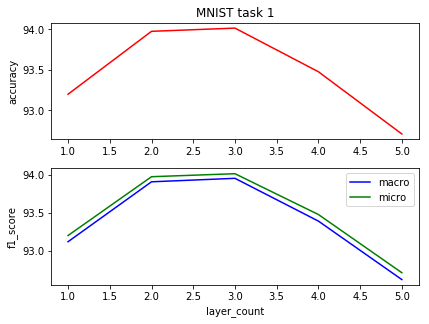

In [71]:
plot("MNISTSigmoid")

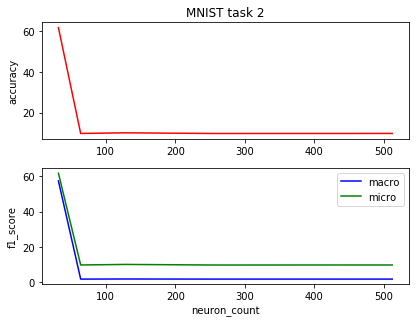

In [77]:
plot("MNISTrelu")

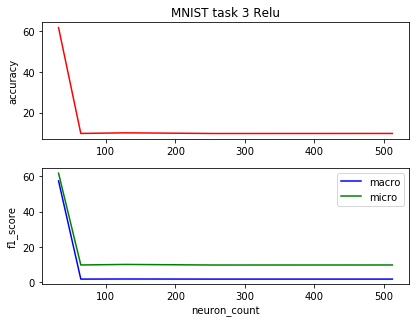

In [9]:
plot("MNISTrelu")

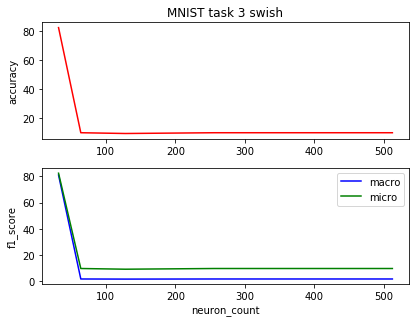

In [17]:
plot("MNISTswish")

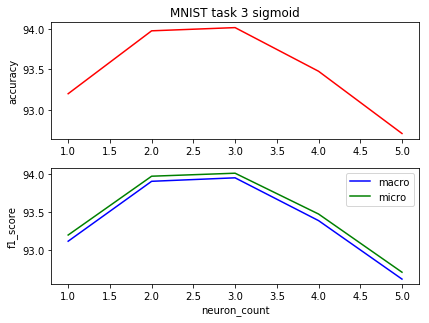

In [19]:
plot("MNISTSigmoid")

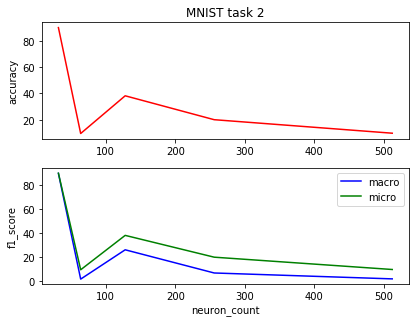

In [75]:
plot('MNISTSigmoidtask2')

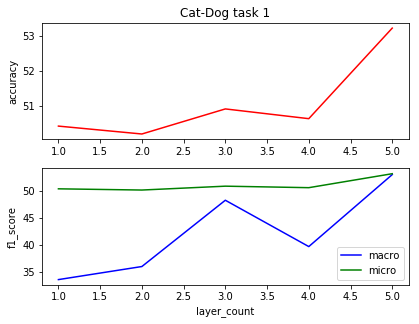

In [63]:
plot("CATSigmoid")

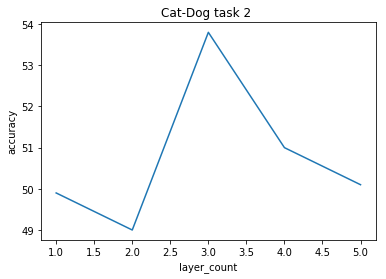

In [12]:
import matplotlib.pyplot as plt
import pickle
def plot_catdog2():
    
    
               
    x = [1,2,3,4,5]
    y= [49.9,49,53.8,51.0,50.1]
    plt.plot(x, y)
    
    plt.ylabel("accuracy")
    plt.title("Cat-Dog task 2 ")
    
    plt.xlabel("layer_count")
    
    
    plt.show()
plot_catdog2()    

In [9]:
import matplotlib.pyplot as plt
import pickle
def plot_catdog():
    
    
               
    x = [100,200,300,400,500]
    y= [49.9,48.4,52.8,51.0,53.1]
    plt.plot(x, y)
    
    plt.ylabel("accuracy")
    plt.title("Cat-Dog task 3 relu")
    
    plt.xlabel("neuron_count")
    
    
    plt.show()

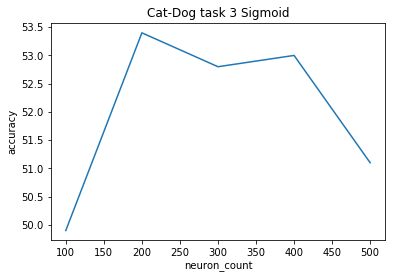

In [8]:
plot_catdog()

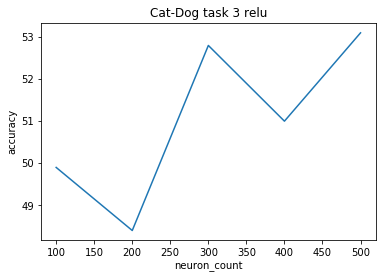

In [10]:
plot_catdog()

In [ ]:
#for i in Y_prediction:
#    print(i)
def Plot_Cat3():
    Accuracy={}
    F1scoremacro={}
    F1scoremicro={}
    batch_size = 64;
    sh = X_train.shape;
    n = sh[1]; #number of features.
    for i in range(1,5):
        config = [30] * i
        config.insert(len(config),2)
        config.insert(0,n)
        
        
        netconfig = np.array(config);
       
        params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,100,"relu");

        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"relu");
        acc = EvaluateAcc(Y_prediction, Y_test);
        
        macro = f1_score( Y_test, Y_prediction,average='macro')
        micro = f1_score( Y_test, Y_prediction,average='micro')
        Accuracy[i] = acc
        F1scoremacro[i] = macro*100
        F1scoremicro[i] =  micro*100
       
    f = open("CATSrelu", "wb")
    pickle.dump(Accuracy,f)
    pickle.dump(F1scoremacro,f)
    pickle.dump(F1scoremicro,f)
    f.close()
    return Accuracy,F1scoremacro,F1scoremicro      
Accuracy,F1scoremacro,F1scoremicro= Plot_Cat3()

In [76]:
batch_size = 64;
netconfig = np.array([n,30,30,30,10]);
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.0001,10000,"relu");

Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"relu");
acc = EvaluateAcc(Y_prediction, Y_test);
print("Accuracy on Neural Network Unified:",acc);

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Accuracy on Neural Network Unified: 58.931830807078796


In [79]:
batch_size = 64;
netconfig = np.array([n,30,15,30,10]);
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.0001,10000,"relu");

Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"relu");
acc = EvaluateAcc(Y_prediction, Y_test);
print("Accuracy on Neural Network Unified:",acc);

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Accuracy on Neural Network Unified: 71.5022617252599


In [80]:
Y_prediction

array([[9.],
       [1.],
       [5.],
       ...,
       [1.],
       [0.],
       [6.]])

In [81]:
batch_size = 64;
netconfig = np.array([n,30,30,10]);
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.0001,10000,"relu");

Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"relu");
acc = EvaluateAcc(Y_prediction, Y_test);
print("Accuracy on Neural Network Unified:",acc);

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Accuracy on Neural Network Unified: 90.18331878422347


In [82]:
Y_prediction

array([[4.],
       [1.],
       [3.],
       ...,
       [1.],
       [0.],
       [6.]])

In [83]:
batch_size = 64;
netconfig = np.array([n,30,10]);
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.0001,10000,"relu");

Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"relu");
acc = EvaluateAcc(Y_prediction, Y_test);
print("Accuracy on Neural Network Unified:",acc);

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Accuracy on Neural Network Unified: 90.79438139830172


In [84]:
batch_size = 64;
netconfig = np.array([n,30,10]);
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.0001,10000,"swish");

Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"swish");
acc = EvaluateAcc(Y_prediction, Y_test);
print("Accuracy on Neural Network Unified:",acc);

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Accuracy on Neural Network Unified: 88.11205459884135


In [17]:
batch_size = 64;
netconfig = np.array([n,30,10]);
params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,10000,"sigmoid");

Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
acc = EvaluateAcc(Y_prediction, Y_test);
print("Accuracy on Neural Network Unified:",acc);

Accuracy on Neural Network Unified: 92.93706848662805


In [40]:
def MNIST_train(dirNameTrain,dirNameTest,config):
        labels = [0,1,2,3, 4,5,6,7,8,9];
        #labels = [0,1];
        X_raw = []
        Y = []
        for label in labels:
            dirName = '../data/MNIST/'+str(label);
            imgList = os.listdir(dirName);
            for img in imgList:
                    X_raw.append(scipy.ndimage.imread(os.path.join(dirName,img)))
                    Y.append(label);

        X_rawTest = []
        Y_Test = []
        for label in labels:
            dirName = dirNameTest + '/' + str(label)
            imgList = os.listdir(dirName);
            for img in imgList:
                    X_rawTest.append(scipy.ndimage.imread(os.path.join(dirName,img)))
                    Y_Test.append(label);

        X = []
        X_Test=[]

        for x in X_raw:
            X.append(x.flatten());
        X = np.array(X);
        Y = np.array(Y).reshape((X.shape[0],1));
        YX = np.concatenate((Y,X),axis=1);

        for x in X_rawTest:
            X_Test.append(x.flatten());
        X_Test = np.array(X_Test);
        Y_Test = np.array(Y_Test).reshape((X_Test.shape[0],1));
        YX_Test = np.concatenate((Y_Test,X_Test),axis=1);

        #YX_train, YX_test = train_test_split(YX, train_size = 0.7);

        X_train = YX[:,1:];
        Y_train = YX[:,0].reshape((YX.shape[0],1));

        X_test = YX_Test[:,1:];
        Y_test = YX_Test[:,0].reshape((YX_Test.shape[0],1));


        X_test = (X_test)/255
        X_train =(X_train)/255
        #print(X_train[0]);
        #print(X_test.shape)
        #print(X_train.shape)

        sh = X_train.shape;
        n = sh[1]; #number of features.






        batch_size = 64;
        config.insert(len(config),10)
        config.insert(0,n)
        
        
        netconfig = np.array(config);
        #print(netconfig)
        params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,10000,"sigmoid");

        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
        acc = EvaluateAcc(Y_prediction, Y_test);
       
        print("Accuracy:",acc)
        print("F1score(macro): ",f1_score( Y_test, Y_prediction,average='macro'))
        print("F1Score(micro) :",f1_score( Y_test, Y_prediction,average='micro'))


In [20]:
MNIST_train('../data/MNIST','../data/MNIST',[30,30,30])

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


[784  30  30  30  10]
Accuracy on Neural Network  95.99761904761904


In [47]:
def MNIST_test(dirNameTest):
        labels = [0,1,2,3, 4,5,6,7,8,9];
        #labels = [0,1];
        X_raw = [];
        Y = []
        for label in labels:
            dirName = dirNameTest+'/'+str(label);
            imgList = os.listdir(dirName);
            for img in imgList:
                X_raw.append(scipy.ndimage.imread(os.path.join(dirName,img)));
                Y.append(label);

        X = [];
        for x in X_raw:
            X.append(x.flatten());
        X = np.array(X);
        Y = np.array(Y).reshape((X.shape[0],1));
        YX = np.concatenate((Y,X),axis=1);

        

        

        X_test = YX[:,1:];
        Y_test = YX[:,0].reshape((YX.shape[0],1));


        X_test = (X_test)/255;
       
        
       
        
        
        f = open("MNISTWeights", "rb")
        params = pickle.load(f)
        f.close()
        
        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
        acc = EvaluateAcc(Y_prediction, Y_test);
        
        print("Accuracy:",acc)
        print("F1score(macro): ",f1_score( Y_test, Y_prediction,average='macro'))
        print("F1Score(micro) :",f1_score( Y_test, Y_prediction,average='micro'))





In [48]:
MNIST_test('../data/MNIST')

Accuracy: 95.08809523809524
F1score(macro):  0.950505955821721
F1Score(micro) : 0.9508809523809524


In [37]:
def CatDog_train(dirNameTrain,dirNameTest,config):
        labels = [0, 1]

        X_raw = []
        Y = []
        animals = ['cat','dog']
        for label in range(2):
            dirName = '../data/Cat-Dog/'+str(animals[label])
            #print(dirName)
            imgList = os.listdir(dirName)
            for img in imgList:
                X_raw.append(plt.imread(os.path.join(dirName,img)))
                Y.append(label)


        X_rawTest = []
        Y_Test = []
        for label in labels:
            dirName = dirNameTest + '/' + str(animals[label])
            imgList = os.listdir(dirName);
            for img in imgList:
                    X_rawTest.append(scipy.ndimage.imread(os.path.join(dirName,img)))
                    Y_Test.append(label);

        X = []
        X_Test=[]

        for x in X_raw:
            X.append(x.flatten());
        X = np.array(X);
        Y = np.array(Y).reshape((X.shape[0],1));
        YX = np.concatenate((Y,X),axis=1);

        for x in X_rawTest:
            X_Test.append(x.flatten());
        X_Test = np.array(X_Test);
        Y_Test = np.array(Y_Test).reshape((X_Test.shape[0],1));
        YX_Test = np.concatenate((Y_Test,X_Test),axis=1);

        #YX_train, YX_test = train_test_split(YX, train_size = 0.7);

        X_train = YX[:,1:];
        Y_train = YX[:,0].reshape((YX.shape[0],1));

        X_test = YX_Test[:,1:];
        Y_test = YX_Test[:,0].reshape((YX_Test.shape[0],1));


        #X_test = (X_test)/256
        #X_train =(X_train)/256
        #print(X_train[0]);
        #print(X_test.shape)
        #print(X_train.shape)

        sh = X_train.shape;
        n = sh[1]; #number of features.
        batch_size = 64;
        config.insert(len(config),2)
        config.insert(0,n)
        
        
        netconfig = np.array(config);
        #print(netconfig)
        params =  trainNeuralNet_unified(X_train, Y_train,netconfig,batch_size,0.03,100,"sigmoid");

        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
        acc = EvaluateAcc(Y_prediction, Y_test);
        print("Accuracy: ",acc);
        print("F1score(macro): ",f1_score( Y_test, Y_prediction,average='macro'))
        print("F1Score(micro): ",f1_score( Y_test, Y_prediction,average='micro'))


In [38]:
CatDog_train('../data/Cat-Dog','../data/Cat-Dog',[30])

../data/Cat-Dog/cat


KeyboardInterrupt: 

In [28]:
def CatDog_test(dirNameTest):
        labels = [0, 1]

        X_raw = []
        Y = []
        animals = ['cat','dog']
        for label in range(2):
            dirName =  dirNameTest+'/'+str(animals[label])
            #print(dirName)
            imgList = os.listdir(dirName)
            for img in imgList:
                X_raw.append(plt.imread(os.path.join(dirName,img)))
                Y.append(label)


        X = [];
        for x in X_raw:
            X.append(x.flatten());
        X = np.array(X);
        Y = np.array(Y).reshape((X.shape[0],1));
        YX = np.concatenate((Y,X),axis=1);
        X_test = YX[:,1:];
        Y_test = YX[:,0].reshape((YX.shape[0],1));
        
        f = open("CatDogWeights", "rb")
        params = pickle.load(f)
        f.close()
        
        Y_prediction =  predictNeuralNet_unified(X_test,netconfig,params,"sigmoid");
        acc = EvaluateAcc(Y_prediction, Y_test);
        print("Accuracy:",acc)
        print("F1score(macro): ",f1_score( Y_test, Y_prediction,average='macro'))
        print("F1Score(micro) :",f1_score( Y_test, Y_prediction,average='micro'))



In [29]:
CatDog_test('../data/Cat-Dog')

/home2/e1-313-15127/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Accuracy on CatDog: 50.0


In [53]:
import nn
from sys import argv
import warnings
warnings.filterwarnings("ignore")
import argparse
import sys
import os




if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--train-data', default= None)
    parser.add_argument('--test-data')
    parser.add_argument('--dataset')
    parser.add_argument('--configuration', nargs ="*")
    args = parser.parse_args()

    if(args.dataset == "MNIST"):
         #if os.path.exists(args.train_data):
        if args.train_data is not None:
                string = args.configuration
                string1 = string[0].strip('[')
                string2 = string[len(string)-1].strip(']')
                string[0] = string[0].strip('[')
                string[len(string)-1] = string[len(string)-1].strip(']')
                results = list(map(int, string))
                nn.MNIST_train(args.train_data,args.test_data,results)

        else:
                nn.MNIST_test(args.test_data)




usage: ipykernel_launcher.py [-h] [--train-data TRAIN_DATA]
                             [--test-data TEST_DATA] [--dataset DATASET]
                             [--configuration [CONFIGURATION [CONFIGURATION ...]]]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/100784/jupyter/kernel-3e25998a-330b-417e-9507-cb942dfbe5b2.json


SystemExit: 2